## Firm Dynamics

### Problem 1:

#### Setting up AR(1) discrete grid:

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import math

# parameters:
sigma_eps = 0.213
mu = 0
rho = 0.7605
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
sizez = 9

# import packages
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)

# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)

# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]



Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


#### VFI:

In [70]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

In [71]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04

In [72]:
beta_firm = (1 / (1 + r))

In [73]:
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / beta_firm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [74]:
# operating profits, op

op = np.zeros((sizez, sizek))
z_grid_exp = np.exp(z_grid)
for i in range(sizez):
    for j in range(sizek):
        op[i, j] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
            (z_grid_exp[i] ** (1 / (1 - alpha_l))) * ((kvec[j] ** alpha_k) ** (1 / (1 - alpha_l))))

# firm cash flow, e
e = np.zeros((sizez, sizek, sizek))
for h in range(sizez):
    for i in range(sizek):
        for j in range(sizek):
            e[h, i, j] = (op[h, i] - kvec[j] + ((1 - delta) * kvec[i]) -
                       ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                        / kvec[i]))

print(np.shape(op), np.shape(e))

(9, 57) (9, 57, 57)


## 3. Value Function Iteration

In [75]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizez, sizek))  # initial guess at value function
Vmat = np.zeros((sizez, sizek, sizek))  # initialize Vmat matrix
#Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

In [76]:
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    V = pi @ V
    for k in range(sizez): # loop over z
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[k, i, j] = e[k, i, j] + beta_firm * V[k, j]

    V = Vmat.max(axis=2)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=2)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')

VF = V  # solution to the functional equation

Value function converged after this many iterations: 366


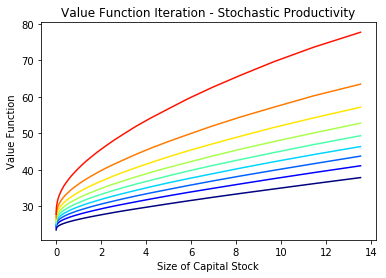

In [80]:
for i in range(sizez):
    plt.plot(kvec, VF[i], color=plt.cm.jet(i / sizez))
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Value Function')
    plt.title('Value Function Iteration - Stochastic Productivity')